<a href="https://colab.research.google.com/github/fresilva-ai/public.ai/blob/main/DiscogsArtistRecommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Cambia la ruta si es necesario
file_path = '/discogs_20250101_artists.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Nos quedamos con columnas clave
df_artistas = df[['artist_name', 'groups_name', 'artist_profile']].dropna()

# Separar múltiples grupos
df_artistas['groups_name'] = df_artistas['groups_name'].str.split(', ')
df_artistas = df_artistas.explode('groups_name')
df_artistas['groups_name'] = df_artistas['groups_name'].str.strip()

# Crear lista única de grupos
grupos = df_artistas['groups_name'].drop_duplicates().reset_index(drop=True).to_frame()

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 4))
tfidf_matrix = vectorizer.fit_transform(grupos['groups_name'])

In [19]:
def recomendar_grupos(favorito, top_n=10):
    favorito = favorito.lower().strip()
    nombres_grupos = grupos['groups_name'].str.lower()

    coincidencias = nombres_grupos[nombres_grupos.str.contains(favorito)]

    if coincidencias.empty:
        print(f"❌ Grupo que contiene '{favorito}' no fue encontrado.")
        print("🔍 ¿Quizás buscabas uno de estos?")
        sugerencias = grupos[grupos['groups_name'].str.lower().str.startswith(favorito[:3])].head(10)
        display(sugerencias)
        return pd.DataFrame()

    idx = coincidencias.index[0]
    cos_sim = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
    indices_similares = cos_sim.argsort()[-top_n-1:-1][::-1]

    resultados = grupos.iloc[indices_similares].copy()
    resultados.reset_index(drop=True, inplace=True)

    # Añadir información adicional desde df_artistas
    resultados = resultados.merge(
        df_artistas[['groups_name', 'artist_name', 'artist_profile']],
        how='left',
        on='groups_name'
    ).drop_duplicates(subset='groups_name')

    def extraer_genero(texto):
        if pd.isna(texto): return ""
        texto = texto.lower()
        generos = ['rock', 'pop', 'jazz', 'metal', 'electronic', 'hip hop', 'funk', 'punk', 'reggae', 'blues']
        return ', '.join([g for g in generos if g in texto])

    resultados['Género aproximado'] = resultados['artist_profile'].apply(extraer_genero)

    # Renombrar columnas para salida clara
    resultados = resultados.rename(columns={
        'groups_name': 'Grupo sugerido',
        'artist_name': 'Artista relacionado',
        'artist_profile': 'Descripción'
    })

    return resultados[['Grupo sugerido', 'Artista relacionado', 'Género aproximado', 'Descripción']]

In [20]:
from IPython.display import display

resultados = recomendar_grupos("nirvana")
display(resultados)

,Grupo sugerido,Artista relacionado,Género aproximado,Descripción
0,Nirvana (2),Peter Kester,,Nirvana (2) drummer
1,Nirvana (4),Daimyo,pop,"Daimyô is a [a15885] double, imitator and show..."
3,Nirvana (6),Krešimir Šoštar,,Croatian guitar player from Zagreb.\nDied arou...
5,Nirvana (9),Rolf Tanzius,,German guitar player
6,Nirvana (14),Dany Cheruelle,,"French musician and sound engineer ([l353584],..."
7,The Nirvana Ensemble,Sylvia Schuster,,Cellist
11,Nirvana 2002,Orvar Säfström,metal,"Swedish journalist, presenter, film critic, de..."
12,Dylan Nirvana & The Bad Flowers,Dylan Nirvana,"pop, punk, blues",Dylan Nirvana is a familiar voice in the New Y...
13,The Servant,Matt Fisher,,UK bassist
14,The Servants,John Mohan,,Guitar player. He was founding member of 'The ...


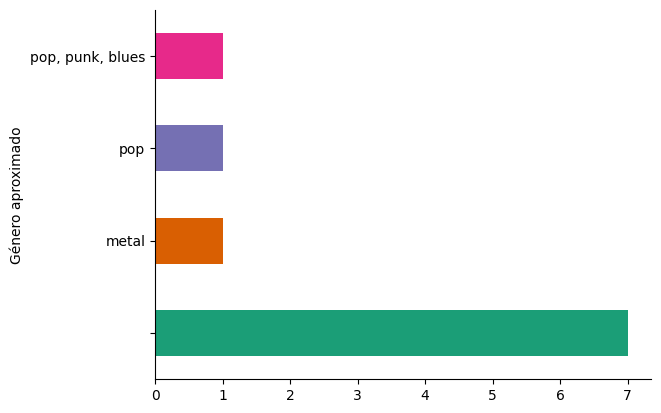

In [22]:
# @title Género aproximado

from matplotlib import pyplot as plt
import seaborn as sns
resultados.groupby('Género aproximado').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)